In [2]:
import pandas as pd
import networkx as nx
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import math
pi = math.pi
np.random.seed(seed=20487)
METHODS_QUERIES = ['spm', 'afni', 'nilearn', 'fsl']
FIELD_QUERY = 'fmri AND language'

In [2]:


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), 
              linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, 
                        alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc

def circum_points(data, radius=10):
    '''
    Generate a dataframe 
    '''
    N = len(data)
    pts = np.ones((N, 2))
    for n in range(0, N):
        pts[n, 0] = math.cos(2*pi/N*n)*radius
        pts[n, 1] = math.sin(2*pi/N*n)*radius
        
    df = pd.DataFrame(data=pts, columns=['x', 'y'], index=data.index)
    df.index = df.index.astype(str)
    return df   


black = [0, 0, 0]

rbgs = {
    'red': [1, 0, 0],
    'green': [0, 1, 0],
    'blue':[0, 0, 1],
    'cyan':[0, 1, 1],
    'purple': [.5, 0, .5],
    
}

rbgs_list = list(rbgs.values())

N = 256
cmaps = []
for n, method in enumerate(METHODS_QUERIES):
    for name, rbg in rbgs.items():
        vals = np.ones((N, 4))
        for comp in range(3):
            vals[:, comp] = np.linspace(rbg[comp], black[comp], N)
        cmaps.append(ListedColormap(vals))

## visualize simulated data

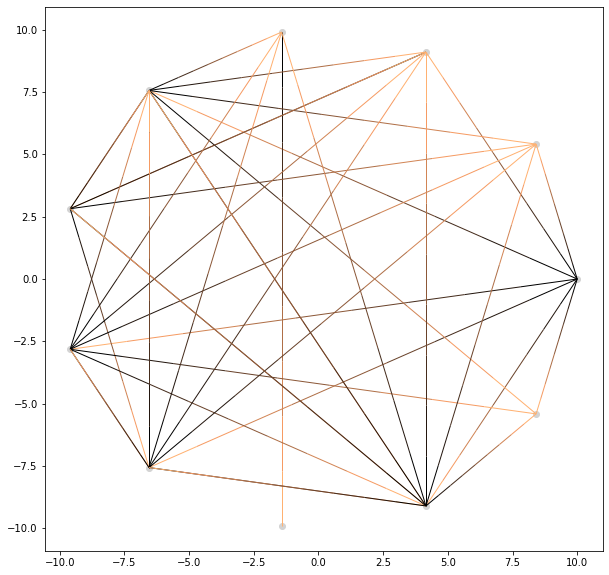

In [3]:
# load simulated data
filename = '../data/simulated_data/adjacency_matrix.csv'
input_data = pd.read_csv(filename, index_col=0)
test = nx.DiGraph(input_data.values)

df = circum_points(data=input_data, radius=10)
plt.figure(figsize=(10,10))
plt.scatter(x=df['x'], y=df['y'], color='lightgrey')
for pmid_r in input_data.index:
    for pmid_c in input_data.index:
        if input_data[pmid_r][pmid_c]:            
            # location of first point
            x1, y1 = df.loc[pmid_r, 'x'], df.loc[pmid_r, 'y']
            
            # location of second point
            x2, y2 = df.loc[pmid_c, 'x'], df.loc[pmid_c, 'y']
            
            x = np.linspace(x1, x2, num=10)
            y = np.linspace(y1, y2, num=10)
            
            # make line between them
            colorline(x, y, cmap='copper', linewidth=1)    
    

In [3]:
data = pd.read_csv('pubmed_data.csv', converters={'refs': eval})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('pmid', drop=True)

In [5]:
mat = pd.read_csv('pubmed_citation_matrix.csv')
mat = mat.set_index('pmid', drop=True)

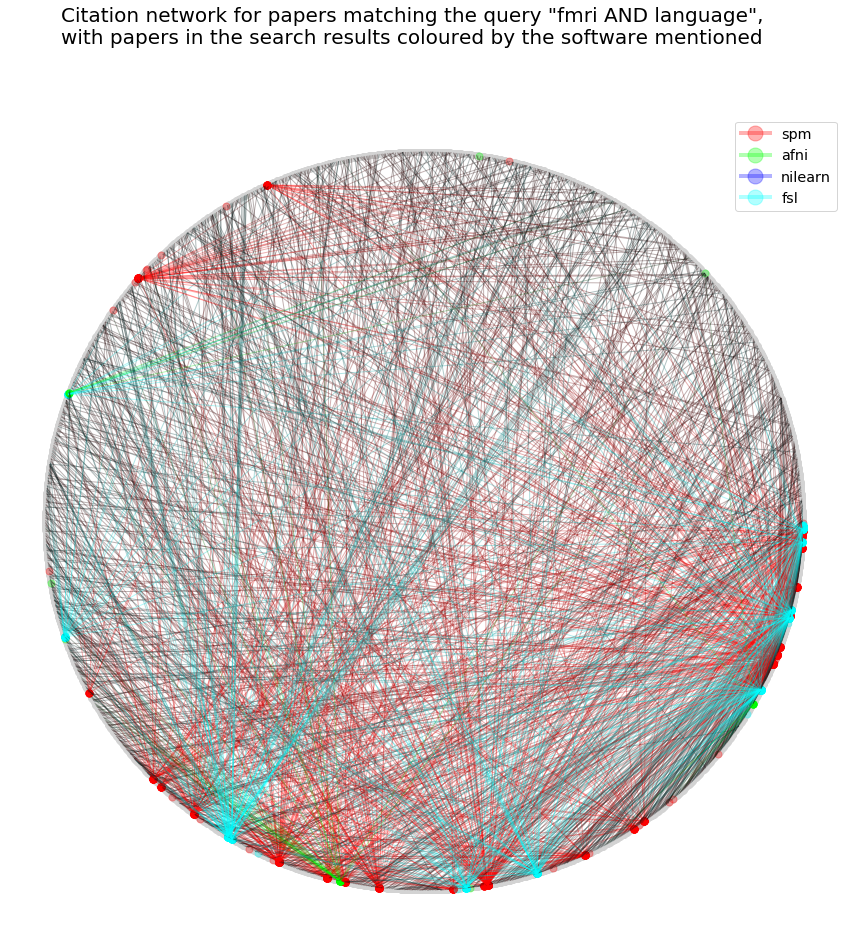

In [6]:
mat = mat
df = circum_points(data=mat, radius=10)
fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(x=df['x'], y=df['y'], color='lightgrey')
for pmid_r in data.index.astype(str):
    for pmid_c in mat.index.astype(str):
        if mat.loc[int(pmid_r), pmid_c] > 0:
            # location of first point
            x1, y1 = df.loc[pmid_r, 'x'], df.loc[pmid_r, 'y']
            
            # location of second point
            x2, y2 = df.loc[pmid_c, 'x'], df.loc[pmid_c, 'y']
            
            x = np.linspace(x1, x2, num=10)
            y = np.linspace(y1, y2, num=10)
            
            # determine colormap based on software used
            for n, method in enumerate(METHODS_QUERIES):
                if data.loc[int(pmid_r), method] > 0:
                    cmap = cmaps[n]
                    color = rbgs_list[n]
                    
            # make bigger coloured dot for article in search results 
            # (not for referenced article)
            alpha = .3
            color = np.expand_dims(np.array(color), axis=0)
            plt.scatter(x1, y1, s=50, c=color, alpha=alpha)
            
            
            # make line between them
            colorline(x, y, cmap=cmap, linewidth=1, alpha=alpha) 
            plt.axis('off')
            
# create legend
custom_lines = []
for n, method in enumerate(METHODS_QUERIES):
    #mpatches.Patch(color='red', label='The red data'
    info = Line2D([0], [0], marker='o', markersize=15, color=rbgs_list[n], lw=4, label=method, alpha=alpha)
    custom_lines.append(info)
plt.legend(handles = custom_lines, fontsize='x-large', loc='upper right')


title = (f'Citation network for papers matching the query \"{FIELD_QUERY}\",\n'
         f'with papers in the search results coloured by the software mentioned')

plt.suptitle(title, fontsize=20)
plt.savefig('../images/results_visualization.png')
